In [38]:
# WhatsApp vs. “Real” Video Classification

# We have ~792 WhatsApp clips (label = 1) and ~618 other videos (label = 0).  
# We’ll extract simple metadata features (size, duration, resolution), run PCA to visualize clusters, and then build a classifier.


In [39]:
#!pip install pandas matplotlib scikit-learn tqdm ffmpeg-python
#!pip install ipywidgets

In [40]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from tqdm import tqdm
from pathlib import Path

In [41]:
whatsapp_dir = Path(r"D:\Classification Pictures\whatsAppVideos")
real_dir = Path(r"D:\Classification Pictures\realVideos")
assert whatsapp_dir.exists() and real_dir.exists()

In [42]:
#Create a pandas dataframe of file path and the corresponding label (whatsAppVideo = 1, realVideos = 0)
rows = []
def assemble():
    for vid in whatsapp_dir.iterdir():
        rows.append({"path": str(vid), "label" : 1})
    for vid in real_dir.iterdir():
        rows.append({"path": str(vid), "label" : 0})
    videos_df = pd.DataFrame(rows)
    return videos_df

videos_df = assemble()
videos_df.head(10)

,path,label
0,D:\Classification Pictures\whatsAppVideos\001a...,1
1,D:\Classification Pictures\whatsAppVideos\003b...,1
2,D:\Classification Pictures\whatsAppVideos\003d...,1
3,D:\Classification Pictures\whatsAppVideos\0083...,1
4,D:\Classification Pictures\whatsAppVideos\00be...,1
5,D:\Classification Pictures\whatsAppVideos\00c2...,1
6,D:\Classification Pictures\whatsAppVideos\00ca...,1
7,D:\Classification Pictures\whatsAppVideos\00dc...,1
8,D:\Classification Pictures\whatsAppVideos\00e3...,1
9,D:\Classification Pictures\whatsAppVideos\00ed...,1


In [45]:
#feature extraction (width, height, duration)
def feature_extraction_video(path: Path):
    cmd = [
        "ffprobe", "-v", "error",
        "-select_streams", "v:0",
        "-show_entries", "stream=width,height,duration",
        "-of", "default=noprint_wrappers=1:nokey=1",
        str(path)
    ]
    try:
        out = subprocess.check_output(cmd, stderr=subprocess.DEVNULL).decode().splitlines()
    except subprocess.CalledProcessError:
        print(f"⚠️ ffprobe failed on {path.name}")
        return 0.0, 0.0, 0.0

    # out might be ['640', '360', 'N/A'] or similar
    def parse_float(s):
        return float(s) if s not in ("N/A", "", None) else 0.0

    # unpack defensively
    if len(out) >= 3:
        w = parse_float(out[0])
        h = parse_float(out[1])
        dur = parse_float(out[2])
    else:
        # unexpected format
        w, h, dur = 0.0, 0.0, 0.0

    return w, h, dur

In [46]:
#Iterate
features = []

for _, row in videos_df.iterrows():
    path = Path(row["path"])
    size = path.stat().st_size 
    w, h, dur = feature_extraction_video(path)
    features.append({"size": size, "width" : w, "height": h, "duration" : dur})
feat_df = pd.DataFrame(features)

⚠️ ffprobe failed on 2016-07-14-VIDEO-00000008[1746].mp4


In [47]:
feat_df

,size,width,height,duration
0,3128896,400.0,400.0,117.506911
1,5072558,244.0,360.0,111.633333
2,3141853,400.0,224.0,132.999678
3,887258,480.0,480.0,17.933333
4,8600433,384.0,288.0,135.800000
...,...,...,...,...
1372,5083593,1280.0,720.0,4.504500
1373,18180528,1280.0,720.0,16.516500
1374,34239711,1280.0,720.0,31.031000
1375,53360816,720.0,420.0,270.080000


In [48]:
full_df = pd.concat([videos_df.reset_index(drop=True), feat_df], axis=1)
X = full_df[["size","width","height","duration"]]
X_scaled = (X - X.mean()) / X.std()

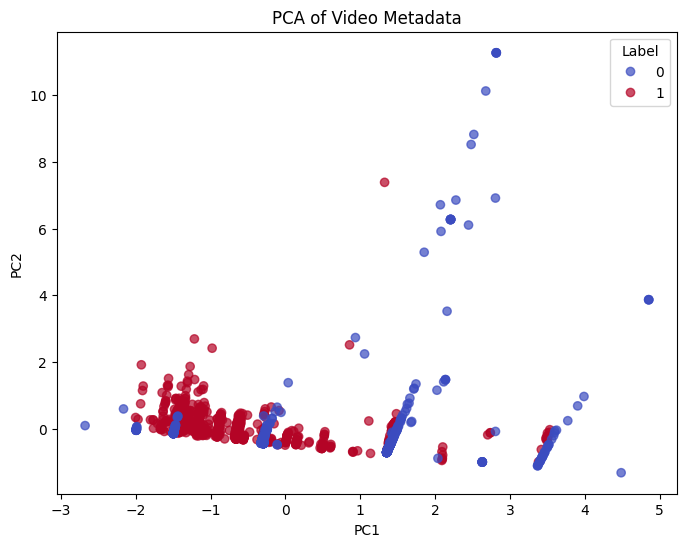

In [54]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)
full_df["PC1"], full_df["PC2"] = pcs[:,0], pcs[:,1]

plt.figure(figsize=(8,6))
scatter = plt.scatter(full_df["PC1"], full_df["PC2"],
                      c=full_df["label"], cmap="coolwarm", alpha=0.7)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA of Video Metadata")
plt.legend(*scatter.legend_elements(), title="Label")
plt.show()


In [55]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=["size","width","height","duration"],
    columns=["PC1","PC2"]
)
display(loadings)

,PC1,PC2
size,0.232203,0.646530
width,0.690494,-0.098627
height,0.683157,-0.174974
duration,0.050966,0.735973


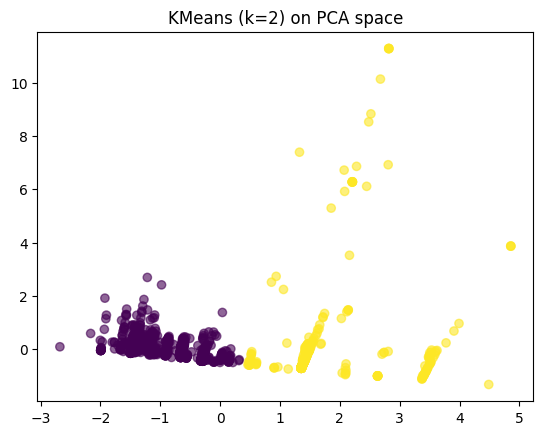

In [59]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2, random_state=0).fit(X_scaled)
plt.scatter(full_df["PC1"], full_df["PC2"], c=km.labels_, cmap="viridis", alpha=0.6)
plt.title("KMeans (k=2) on PCA space")
plt.show()

In [60]:
!pip install torchvision

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/e4/cf/8f9305cc0ea26badbbb3558ecae54c04a245429f03168f7fad502f8a5b25/torchvision-0.22.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torch==2.7.0 from https://files.pythonhosted.org/packages/13/85/6c1092d4b06c3db1ed23d4106488750917156af0b24ab0a2d9951830b0e9/torch-2.7.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/4d/36/2a115987e2d8c300a974597416d9de88f2444426de9571f4b59b2cca3acc/filelock-3.18.0-py3-none-any.whl.metadata
  Obtaining dependency information for sympy>=1.13.3 from https://files.pythonhosted.org/packages/a2/09/77d55d46fd61b4a135c444fc97158ef34a095e5681d0a6c10b75bf356191/sympy-1.14.0-py3-none-any.whl.metadata
  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/b9/54/dd730b32ea14ea797530a4479b2ed46a6fb250f682a9cfb997e968bf0261/networ


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [71]:
from torchvision import models, transforms
import torch
import cv2

# 1) Load ResNet
resnet = models.resnet50(pretrained=True)
resnet.eval()
# Strip off the last FC
embed_fn = torch.nn.Sequential(*list(resnet.children())[:-1])

# 2) Define transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# 3) Embed one video
def embed_video(path):
    cap = cv2.VideoCapture(str(path))
    frames = []
    count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in np.linspace(0, count-1, num=5, dtype=int):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, img = cap.read()
        if not ret: break
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        t = preprocess(Image.fromarray(img)).unsqueeze(0)
        with torch.no_grad():
            feat = embed_fn(t).squeeze().numpy()
        frames.append(feat)
    cap.release()
    return np.mean(frames, axis=0)


C:\Users\Spart\OneDrive\Desktop\video_dedupe\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Spart\OneDrive\Desktop\video_dedupe\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [73]:
import numpy as np
from tqdm.auto import tqdm
import cv2
from PIL import Image
paths, labels, embeds = [], [], []
for p in tqdm(whatsapp_dir.iterdir(), desc="WhatsApp"):
    paths.append(str(p)); labels.append(1)
    embeds.append(embed_video(p))
for p in tqdm(real_dir.iterdir(), desc="Real"):
    paths.append(str(p)); labels.append(0)
    embeds.append(embed_video(p))

X = np.vstack(embeds)       # shape: (n_samples, 2048)
y = np.array(labels)        # shape: (n_samples,)

WhatsApp: 759it [02:59,  4.23it/s]
Real: 617it [02:56,  3.50it/s]


In [75]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Real","WhatsApp"]))

              precision    recall  f1-score   support

        Real       0.90      0.93      0.91       124
    WhatsApp       0.94      0.91      0.93       152

    accuracy                           0.92       276
   macro avg       0.92      0.92      0.92       276
weighted avg       0.92      0.92      0.92       276



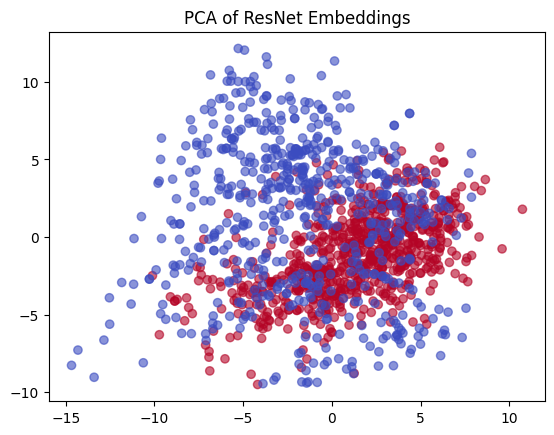

In [76]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pcs = pca.fit_transform(X)
plt.scatter(pcs[:,0], pcs[:,1], c=y, cmap="coolwarm", alpha=0.6)
plt.title("PCA of ResNet Embeddings")
plt.show()


In [79]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RandomForest performance:")
print(classification_report(y_test, y_pred_rf, target_names=["Real","WhatsApp"]))


RandomForest performance:
              precision    recall  f1-score   support

        Real       0.92      0.94      0.93       124
    WhatsApp       0.95      0.93      0.94       152

    accuracy                           0.94       276
   macro avg       0.94      0.94      0.94       276
weighted avg       0.94      0.94      0.94       276



In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1) Train the Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 2) Evaluate on the held-out test set
y_pred_rf = rf.predict(X_test)
print("🔍 RandomForestClassifier performance:")
print(classification_report(y_test, y_pred_rf, target_names=["Real","WhatsApp"]))

🔍 RandomForestClassifier performance:
              precision    recall  f1-score   support

        Real       0.91      0.95      0.93       124
    WhatsApp       0.96      0.93      0.94       152

    accuracy                           0.94       276
   macro avg       0.94      0.94      0.94       276
weighted avg       0.94      0.94      0.94       276



In [89]:
from sklearn.metrics import f1_score
probs = rf.predict_proba(X_test)[:,1]
best = (0.5, 0)
for t in np.linspace(0.3, 0.7, 21):
    preds = (probs > t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best[1]:
        best = (t, f1)
print(f"Best threshold {best[0]:.2f} → F1 {best[1]:.3f}")

Best threshold 0.48 → F1 0.947


In [91]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

def f1_at_048(y_true, y_proba):
    return f1_score(y_true, (y_proba[:,1] > 0.48).astype(int))

scorer = make_scorer(f1_at_048, needs_proba=True)
scores = cross_val_score(rf, X, y, cv=5, scoring=scorer, n_jobs=-1)
print("CV F1 @0.48:", scores.round(3), "→ mean", scores.mean().round(3))


CV F1 @0.48: [nan nan nan nan nan] → mean nan


              precision    recall  f1-score   support

        Real       0.91      0.93      0.92       124
    WhatsApp       0.94      0.92      0.93       152

    accuracy                           0.92       276
   macro avg       0.92      0.92      0.92       276
weighted avg       0.92      0.92      0.92       276

